In [6]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.models import ResNet101_Weights # Add this import
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #gpu or cpu
print(f"Using device: {device}")

Using device: cuda


In [8]:
# for cleaning curropted images
from PIL import Image, UnidentifiedImageError
import os

def remove_corrupted_images(folder):
    num_deleted = 0
    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()
            except (UnidentifiedImageError, OSError):
                print(f"Deleting corrupted image: {path}")
                os.remove(path)
                num_deleted += 1
    print(f"Deleted {num_deleted} corrupted images.")

# Clean the full dataset
remove_corrupted_images("dataset")

Deleted 0 corrupted images.


In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), #coz ResNet ins 224*224 size only
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], #normalizing pixel avlue
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
valid_dataset = datasets.ImageFolder('dataset/valid', transform=transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# Load the pretrained model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  #2 o/p classes: cat and dog

# Move the model to the appropriate device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\Shivam/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [02:30<00:00, 1.19MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [13]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')

Epoch 1/5 - Loss: 0.0802 - Acc: 0.9746
Epoch 2/5 - Loss: 0.0436 - Acc: 0.9844
Epoch 3/5 - Loss: 0.0378 - Acc: 0.9865
Epoch 4/5 - Loss: 0.0339 - Acc: 0.9879
Epoch 5/5 - Loss: 0.0293 - Acc: 0.9901


In [14]:
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_dataset)
print(f'Test Accuracy: {100*test_acc:.4f}')

Test Accuracy: 98.7610


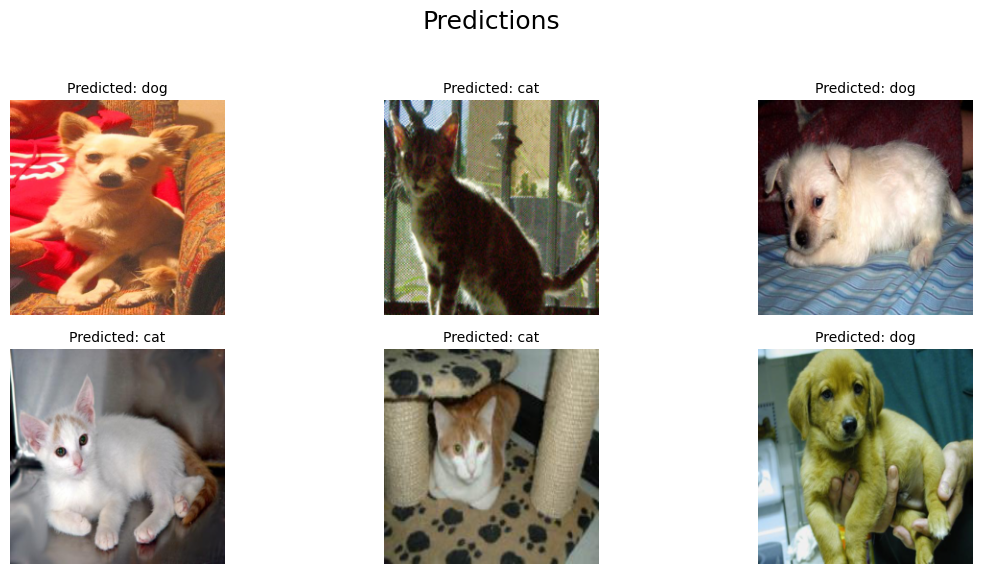

In [18]:
N = 6
rows, cols = 2, 3
class_names = ['cat', 'dog']
random_indices = random.sample(range(len(test_dataset)), N)
images = [test_dataset[i][0] for i in random_indices]
labels = [test_dataset[i][1] for i in random_indices]
inputs = torch.stack(images).to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.suptitle('Predictions', fontsize=18)

for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean  #de-normalize
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(f"Predicted: {class_names[preds[i]]}", fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()